In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random # to randomize our batch data

import torch
import torchvision
import torchvision.transforms as transforms # to transform our images # normalize
import torchvision.models as models # to import pre-trained models

from torch.autograd import Variable # let our network automatically implement back propogation
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import itertools
from sklearn.metrics import confusion_matrix
from scipy.io import savemat # to save our features representations
from scipy.io import loadmat # to load our features representations
from sklearn import svm # to check our accuracy

from sklearn.cluster import MiniBatchKMeans, KMeans

import time # to record our work's time
import pickle
print ('OpenCV version = ' + cv2.__version__)

OpenCV version = 3.4.1


In [4]:
# just something for the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
#     print(cm) # uncomment if you want to print like normal data
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [80]:
# function to just plot both normalizes and normal matrix

def print_confusion_matrix(test_label, predictions):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(test_label, predictions)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names_matrix, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [6]:
#Prepare dataset

# function to parse the actions.txt file to get the name of all actions
# function to parse the file whose filename is passed
# return type: data set of all the class names
def get_typemoney_classes(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('  ')
                category.append(record[1])
    return category

In [7]:
# function to parse the videos_labels_subsets.txt file 
# to get all the labels associated with each set of video representation
#function to parse the file whose filename is passed
#return type: train,train_labels, test, test_labels
def get_image_labels(fileName):
    File = str(fileName)
    row = []
    category = []
    with open(File) as inFile: #opening the file to scrap data
        for line in inFile: #separating each line
            items = line.strip().split(',') #splits the string into an array
            for each in items:
                record = each.strip().split('\t')
                row.append(record)
    return seperate_data(row) # return data set

In [8]:
# a helper function for get_image_labels(filename)
# gets the labels and tag associated with each video 
# and divides them into test and training data names and labels
#return type: train,train_labels, test, test_labels
def seperate_data(label_names):
    train = []
    test = []
    train_labels = []
    test_labels = []
    for item in label_names:
        if (item[2]=='1'):
            train.append(item[0])
            train_labels.append(int(item[1]))
        else:
            test.append(item[0])
            test_labels.append(int(item[1]))
    return train, train_labels, test, test_labels

In [9]:
file_annos = './data/annos.txt'
file_images = './data/images_labels_subsets.txt'

In [10]:
class_names_all = get_typemoney_classes(file_annos) #get all action names
class_names = dict(zip(range(1, len(class_names_all)+1), class_names_all))
# change it into a dictionary for each access

print("The visual system is made to recognise the following tasks:")
[(print(x,"|", class_names[x])) for x in class_names]

# get all labels and name of training and test data features
train, train_labels, test, test_labels = get_image_labels(file_images)

The visual system is made to recognise the following tasks:
1 | 500vnd
2 | 1000vnd
3 | 2000vnd
4 | 5000vnd
5 | 10000vnd
6 | 20000vnd
7 | 50000vnd
8 | 100000vnd
9 | 200000vnd
10 | 500000vnd


In [11]:
print("In total, we would have", len(train)+len(test), "number of data representation.")
print("The size of the training set is",len(train_labels),".")
print("The size of the test set is",len(test_labels),".")
print("The number of classes in the dataset is", len(class_names),".")

In total, we would have 200 number of data representation.
The size of the training set is 140 .
The size of the test set is 60 .
The number of classes in the dataset is 10 .


In [12]:
# function to show a passed image
def imshow(img):
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()

In [13]:
# function which returns a list of cropped images for a passed image
# works with images passed as normal numpy array or a tensor
# passed argument: image itself, what size you want the crops to be
# returns only a list of numpy cropped images
# uncomment to change into tensors for tensors
def get_five_crops(img, size):
    s_h, s_w = size
    crop = []
    is_tensor = torch.is_tensor(img)
    # change into a numpy array properly if it is tensor
    # Tensor image's shape -> channels*height*width
    # Numpy image's shape -> height*width*channels
    if (is_tensor):
        temp = img.numpy()
        temp = np.transpose(temp, [1, 2, 0])
        img = temp
        
    height, width, color = img.shape
    crop.append(img[0:s_h, 0:s_w]) #image 1
    crop.append(img[0:s_h, (width-s_w):width]) #image 2
    crop.append(img[(height-s_h):height, 0:s_w]) #image 3
    crop.append(img[(height-s_h):height, (width-s_w):width]) #image 4
    mid_y = int(height/2 - s_h/2)
    mid_x = int(width/2 - s_w/2)
    crop.append(img[mid_y:(mid_y + s_h), mid_x:(mid_x + s_w)]) # image 5 # center

#     uncomment to change into tensors for tensors
#     if (is_tensor):
#         for i, each in enumerate(crop):
#             crop[i] = torch.from_numpy(each.transpose(2,0,1))
    return crop 

In [14]:
# function to normalize a given image
# returns normalized tensors
def img_norm(img):
    #norm the images
    #size = (300,300)
    size = (224, 224)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    return prep(img) #to prepare the image

In [15]:
# function which prepares the image
# first normalizes
# then extracts the 5 crops of the normalized pictures
# and returns it as a list
def prep_img(img, img_size):
    return (get_five_crops(img_norm(img), img_size))

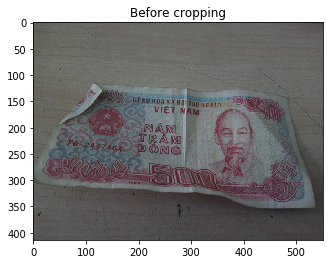

In [16]:
img = cv2.imread('data/vnmoney/00/1.jpg')
plt.figure()
plt.title('Before cropping')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

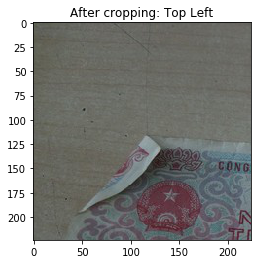

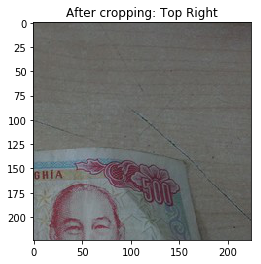

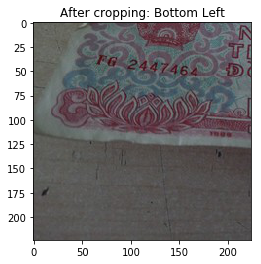

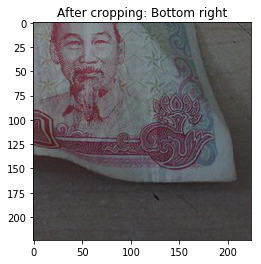

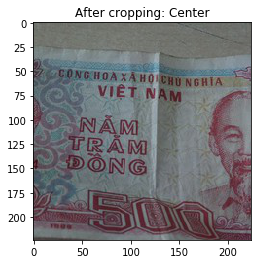

In [79]:
#img_size = (300, 300)
img_size = (224, 224)
img = cv2.imread('data/vnmoney/00/1.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']
for i, img1 in enumerate(get_five_crops(img, img_size)):
    plt.figure()
    plt.title('After cropping: ' + arr[i])
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    plt.show()

In [18]:
def load_dataset(path, data_name, img_size, batch_num=1, is_color=False):
    data = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
    
    for image_name in data_name:
        filename = path+image_name+".jpg"
        img = cv2.imread(filename)
        crops = prep_img(img, img_size)
        for each in crops:
            data.append(np.transpose(each, [2, 0, 1]))
        
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
        data = batch_data
        
    return data

In [19]:
#get data to extract feature | now train data
s = time.clock()
#img_size = (300, 300)
img_size = (224, 224)
batch_num = 5 # samples number per batch 
path = 'data/vnmoney/'
# load train dataset for feature extraction
vnmoney_train_data = load_dataset(path, train, img_size, batch_num=batch_num, is_color=True)
vnmoney_train_num = len(vnmoney_train_data)

# load train dataset for feature extraction
vnmoney_test_data = load_dataset(path, test, img_size, batch_num=batch_num, is_color=True)
vnmoney_test_num = len(vnmoney_test_data)

print ("Finish loading %d minibatches(=%d) of train samples." % (vnmoney_train_num, batch_num))
print ("Finish loading %d minibatches(=%d) of test samples." % (vnmoney_test_num, batch_num))
e = time.clock()

print("Time Taken: ", int((e-s)//60), "min and", float((e-s)%60),"sec")

Finish loading 140 minibatches(=5) of train samples.
Finish loading 60 minibatches(=5) of test samples.
Time Taken:  0 min and 5.183071999999999 sec


In [20]:
print ("The dimension of the loaded TRAIN dataset is " + str(len(vnmoney_train_data)) + "*"  + str(len(vnmoney_train_data[0])) + "*" + str(len(vnmoney_train_data[0][0])) + "*" + str(len(vnmoney_train_data[0][0][0])) + "*" + str(len(vnmoney_train_data[0][0][0][0])))
#3625*5*3*224*224
print("There are",str(len(vnmoney_train_data)),"minibatches.")
print ("There are",str(len(vnmoney_train_data[0])),"images in each minibatch.")
print ("There are",str(len(vnmoney_train_data[0][0])),"channels for each image.")
print ("The shape for each image is ",str(len(vnmoney_train_data[0][0][0])),"*",str(len(vnmoney_train_data[0][0][0][0])))

The dimension of the loaded TRAIN dataset is 140*5*3*224*224
There are 140 minibatches.
There are 5 images in each minibatch.
There are 3 channels for each image.
The shape for each image is  224 * 224


In [21]:
print ("The dimension of the loaded TEST dataset is " + str(len(vnmoney_test_data)) + "*"  + str(len(vnmoney_test_data[0])) + "*" + str(len(vnmoney_test_data[0][0])) + "*" + str(len(vnmoney_test_data[0][0][0])) + "*" + str(len(vnmoney_test_data[0][0][0][0])))
#3625*5*3*224*224
print("There are",str(len(vnmoney_test_data)),"minibatches.")
print ("There are",str(len(vnmoney_test_data[0])),"images in each minibatch.")
print ("There are",str(len(vnmoney_test_data[0][0])),"channels for each image.")
print ("The shape for each image is ",str(len(vnmoney_test_data[0][0][0])),"*",str(len(vnmoney_test_data[0][0][0][0])))

The dimension of the loaded TEST dataset is 60*5*3*224*224
There are 60 minibatches.
There are 5 images in each minibatch.
There are 3 channels for each image.
The shape for each image is  224 * 224


## 2.1 Feature extraction
---
+ Extract features using pretrain VGG16

In [290]:
# we use vgg16 for feature extraction
# we use the first 4096-dim as features
vgg16 = models.vgg16(pretrained=True) # takes in images of 224*224

print("The structure of the VGG16 model.")

The structure of the VGG16 model.


In [291]:
# function to modify the classifier
def change_classifier(classifier, position):
    temp_clas = list(classifier)
    temp_clas = temp_clas[0:position+1]
    temp_clas = nn.Sequential(*temp_clas)
    return temp_clas

In [292]:
print ("Before modifying the VGG classifier:")

#here i just kept the first linear layer  and ReLU that gives 4096-dim features
print ("After modifying the VGG classifier:")
vgg16.classifier = change_classifier(vgg16.classifier, 1)


Before modifying the VGG classifier:
After modifying the VGG classifier:


In [293]:
# given a set of features, and the index of the video name
# it saves the video to .Mat format using scipy
def save_features(path, batch_num, data, j):
    data = np.array(data)
    batch_num #for every 20 4096-dim, we make a matrix of 20*4096
    # batch num varies according to how many sequential data you have.
    
    print("\t This file has about " + str(len(data)) + " pictures.")
    for i in range(int(len(data) /batch_num)): # not much of a requirement to do this because in this particular case, we only loop once everytime
        mini = np.array(data[i*batch_num: (i+1)*batch_num],dtype = 'float32')
        d = {}
        d['Feature'] = mini #features.data.numpy()
        name = class_names[j] #geeting the actual name of the file
        j+=1
        savemat(path+ name, d) # to save feature to '.mat' file 

In [294]:
# when given a tensor of outputs, it returns an average of it in list format
def avg_outputs(features):
    # each passed feature is of the shape (5,4096)
    data = []
    for each in features: #changing each tensor in the passed array to a numpy array 
        data.append((each.data).numpy())
    # axis 0 just means, you are adding parallely in the axis of 4096 dimension
    return (np.sum(data, axis = 0)/len(features)).tolist() 
    #divide by the length and change it to a list 

In [357]:
def extract_vgg16_features():    
    ########################################-----TRAIN-----############################################
    s = time.clock()
    features = [] # array to store data for each video sample
    i = 0 # index to keep track of the batch number
    j = 1 # index to keep track of which video we are extracting
    temp = [] # array to store each minibatch

    for data in vnmoney_train_data: # looping over each mini-batch
        print ("Batch: " + str (i)) #tracking the batches
        images = data # input is 5 crop image have same class size(224x224x3)

        outputs = vgg16(Variable(images)) #using the pre-trained network to get outputs
        del images # deleting images because we already extracted the features
        for each in outputs: # as each minibatch equals 1 frame
            temp.append(each) # we put it into an array so that we can average it easily
        del outputs # free up more space
        features.append(avg_outputs(temp)) #averaging cropped images and creating the sequential data
        temp = [] # free up more space
        if (len(features) == 14): #for every 14 images, we have a video sample 
            save_features('train_vgg16_features/', 14, features,j) #save the video features with the jth name
            print ("\t Image saved: " + class_names[j]) 
            j+=1
            features = [] # clear up memory after saving
        i+=1
    
        e = time.clock()
        print("Time Taken: " +str(e-s))
    
    print("Done extract feature image on train data") #print after finishing
    
    ########################################-----TEST-----############################################
    s = time.clock()
    features = [] # array to store data for each video sample
    i = 0 # index to keep track of the batch number
    j = 1 # index to keep track of which video we are extracting
    temp = [] # array to store each minibatch

    for data in vnmoney_test_data: # looping over each mini-batch
        print ("Batch: " + str (i)) #tracking the batches
        images = data # input is 5 crop image have same class size(224x224x3)
        
        outputs = vgg16(Variable(images)) #using the pre-trained network to get outputs
        del images # deleting images because we already extracted the features
        for each in outputs: # as each minibatch equals 1 frame
            temp.append(each) # we put it into an array so that we can average it easily
        del outputs # free up more space
        features.append(avg_outputs(temp)) #averaging cropped images and creating the sequential data
        temp = [] # free up more space
        if (len(features) == 6): #for every 6 images, we have a video sample 
            save_features('test_vgg16_features/', 6, features,j) #save the video features with the jth name
            print ("\t Image saved: " + class_names[j]) 
            j+=1
            features = [] # clear up memory after saving
        i+=1
    
        e = time.clock()
        print("Time Taken: " +str(e-s))
    
    print("Done extract feature image on test data") #print after finishing

## 2.2 Feature extraction
---
+ Extract features using SIFT

In [22]:
def cluster_features(img_descs, cluster_model):
    """
    Cluster the training features using the cluster_model
    and convert each set of descriptors in img_descs
    to a Visual Bag of Words histogram.

    Parameters:
    -----------
    X : list of lists of SIFT descriptors (img_descs)

    training_idxs : array/list of integers
        Indicies for the training rows in img_descs

    cluster_model : clustering model (eg KMeans from scikit-learn)
        The model used to cluster the SIFT features

    Returns:
    --------
    cluster_mode :
    cluster_model has been fit to the training set
    """
    n_clusters = cluster_model.n_clusters
    des_stack_train=[desc for img in img_descs for desc in img]
    all_train_descriptors = np.array(des_stack_train)

    if all_train_descriptors.shape[1] != 128:
        raise ValueError('Expected SIFT descriptors to have 128 features, got', all_train_descriptors.shape[1])

    print ('%i descriptors before clustering' % all_train_descriptors.shape[0])

    # Cluster descriptors to get codebook
    print ('Using clustering model %s...' % repr(cluster_model))
    print ('Clustering on training set to get codebook of %i words' % n_clusters)

    # train kmeans or other cluster model on those descriptors selected above
    cluster_model.fit(all_train_descriptors)
    print ('done clustering.')

    return cluster_model

In [23]:
def histogram(cluster_model,des,K):
    words = cluster_model.predict(des)
    img_bow_hist = np.array([np.bincount(words, minlength=K)])
    return img_bow_hist

In [24]:
def cluster_split(_X_train, _Y_train, _X_test, _Y_test, K):
    
    print ('\n computing descriptors of training data and producing corresponding labels')
    
    des_train, Y_train = decs_train(_X_train, _Y_train)
    
    # building cluster model
    cluster_model = cluster_features(des_train, cluster_model=MiniBatchKMeans(n_clusters=K))
    
    X_train=[]   # initialising array of input vectors for training set
    
    print ('\n calculting histogram vectors of training set')
    for des in des_train:
        hist=histogram(cluster_model,des,K)
        X_train.append(hist)
    X_train=np.array(X_train)
    
    # building validation set in terms of labels and vectors
    #X_val=[]
   # print '\n computing descriptors of validation data and producing corresponding labels'
    #des_val,Y_val=decs_train(validation,labeled_data)
    
   # print '\n calculting histogram vectors of validation set'
   # for des in des_val:
     #   hist=histogram(cluster_model,des,K)
     #   X_val.append(hist)
    #X_val=np.array(X_val)
    
    # building test set in terms of labels and vectors
    X_test=[]
    print ('\n computing descriptors of test data and producing corresponding labels')
    des_test,Y_test=decs_train(_X_test, _Y_test)
    
    print ('\n calculting histogram vectors of test set')
    for des in des_test:
        hist=histogram(cluster_model, des, K)
        X_test.append(hist)
    X_test=np.array(X_test)
    return X_train, Y_train, X_test, Y_test, cluster_model

In [36]:
def extract_SIFT_feature():
    ########################################-----TRAIN-----############################################
    s = time.clock()
    features = [] # array to store data for each video sample
    i = 0 # index to keep track of the batch number
    j = 1 # index to keep track of which video we are extracting
    temp = [] # array to store each minibatch

    for data in vnmoney_train_data: # looping over each mini-batch
        print ("Batch: " + str (i)) #tracking the batches
        images = data # input is 5 crop image have same class size(224x224x3)
       
        outputs =sift(images) #using the pre-trained network to get outputs
        break
#         del images # deleting images because we already extracted the features
#         for each in outputs: # as each minibatch equals 1 frame
#             temp.append(each) # we put it into an array so that we can average it easily
#         del outputs # free up more space
#         features.append(avg_outputs(temp)) #averaging cropped images and creating the sequential data
#         temp = [] # free up more space
#         if (len(features) == 14): #for every 14 images, we have a video sample 
#             save_features('train_vgg16_features/', 14, features,j) #save the video features with the jth name
#             print ("\t Image saved: " + class_names[j]) 
#             j+=1
#             features = [] # clear up memory after saving
#         i+=1
    
#         e = time.clock()
#         print("Time Taken: " +str(e-s))
    
    print("Done extract feature image on train data") #print after finishing

In [70]:
def sift(images):
    sift = cv2.xfeatures2d.SIFT_create()
    dess = []
    for i in images:
        img = np.reshape(i.numpy(), (224, 224, 3))
        print(img)
        _, des = sift.detectAndCompute(img, None)
        dess.append(des)
    print(dess)
    return dess

In [353]:
# ======================================================
#    Load Training and Testing Features Representations
# ======================================================

def load_feature_dataset(path, matrix_size, data_names, data_labels, batch_num=1):
    labels = data_labels
    names = []
     
    data = (loadmat( path + class_names[1] +'.mat'))['Feature']
    
    for i in range(2, len(class_names)+1):
        print("---->load: "+path+class_names[i]+'.mat')
        feat = (loadmat( path + class_names[i] +'.mat'))['Feature']
        #data.append(feat)
        data = np.concatenate((data, feat), axis=0)
    print(int(len(data)))
    if batch_num >= 1:
        batch_data = []
        batch_labels = []
        for i in range(int(len(data) / batch_num)):
            minibatch_d = np.array(data[i*batch_num: (i+1)*batch_num])
            #print(len(minibatch_d), i*batch_num, (i+1)*batch_num)
            minibatch_d = np.reshape(minibatch_d, (batch_num, matrix_size[0], matrix_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            
            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
    return list(zip(batch_data, batch_labels))

In [354]:
# train_feature_path = 'train_vgg16_features/'
# test_feature_path = 'test_vgg16_features/'

train_feature_path = 'train_SIFT_features/'
test_feature_path = 'test_SIFT_features/'

s = time.clock()
matrix_size = (1,4096) #defines the size of the sequence and size of each feature
batch_num = 5 # training sample number per batch 

# load training dataset
train_data = load_feature_dataset(train_feature_path, matrix_size, train, train_labels, batch_num=batch_num)
train_num = len(train_data)
print ("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
test_data = load_feature_dataset(test_feature_path, matrix_size, test, test_labels, batch_num=batch_num)
test_num = len(test_data)
print ("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

e = time.clock()
print("Time Taken: "+ str(e-s))

---->load: train_features/1000vnd.mat
---->load: train_features/2000vnd.mat
---->load: train_features/5000vnd.mat
---->load: train_features/10000vnd.mat
---->load: train_features/20000vnd.mat
---->load: train_features/50000vnd.mat
---->load: train_features/100000vnd.mat
---->load: train_features/200000vnd.mat
---->load: train_features/500000vnd.mat
140
Finish loading 28 minibatches(=5) of training samples.
---->load: test_features/1000vnd.mat
---->load: test_features/2000vnd.mat
---->load: test_features/5000vnd.mat
---->load: test_features/10000vnd.mat
---->load: test_features/20000vnd.mat
---->load: test_features/50000vnd.mat
---->load: test_features/100000vnd.mat
---->load: test_features/200000vnd.mat
---->load: test_features/500000vnd.mat
60
Finish loading 12 minibatches(=5) of testing samples.
Time Taken: 0.022021000000222557


In [315]:
# function to extra features and labels into a long vector to train the SVM
def extract_list(batch_data):
    data = []
    rlabels = []
    for item in batch_data:
        feat, labels = item
        for i in feat:
            each = np.array(i.numpy())
            each = np.reshape(each, (len(each)*len(each[0])))
            data.append(each)
        for j in labels:
            rlabels.append(j)
    return data, rlabels

In [316]:
# extracting training data for SVM
train_data_svm, train_labels_svm = extract_list(train_data)
# extracting testing data for SVM
test_data_svm, test_labels_svm = extract_list(test_data)

In [317]:
classifier_svm = svm.LinearSVC()

# As my machine is not capable of doing an SVM of all training data at once

s= time.clock()
print ("Training Started...")
classifier_svm.fit(np.array(train_data_svm), train_labels_svm) #fitting and training
print ("Training Finished...")
e = time.clock()
print ("Time Taken : " + str(e-s))

Training Started...
Training Finished...
Time Taken : 1.531688000000031


/home/trimo/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [318]:
svm_save  = classifier_svm.get_params(True)
print (svm_save)

# save the classifier
with open('vgg16_svm_model/svm_classifier.pkl', 'wb') as fid:
    pickle.dump(classifier_svm, fid)    

{'C': 1.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 1000, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': None, 'tol': 0.0001, 'verbose': 0}


In [319]:
# method for getting accuracy when a train label set and test label set is passed
def get_accuracy(actual_label, predicted_label):
    accuracy = sum(np.array(actual_label) == predicted_label) / float(len(actual_label))
    return accuracy

In [320]:
# training accuracy
predicted_train_labels_svm = classifier_svm.predict(train_data_svm) # getting the predicted labels
S = get_accuracy(train_labels_svm , predicted_train_labels_svm) # getting the accuracy
print ("The training accuracy of my model using SVM is {:.2f}%".format(S*100))

The training accuracy of my model using SVM is 100.00%


{1: '500vnd', 2: '1000vnd', 3: '2000vnd', 4: '5000vnd', 5: '10000vnd', 6: '20000vnd', 7: '50000vnd', 8: '100000vnd', 9: '200000vnd', 10: '500000vnd'}


<Figure size 432x288 with 0 Axes>

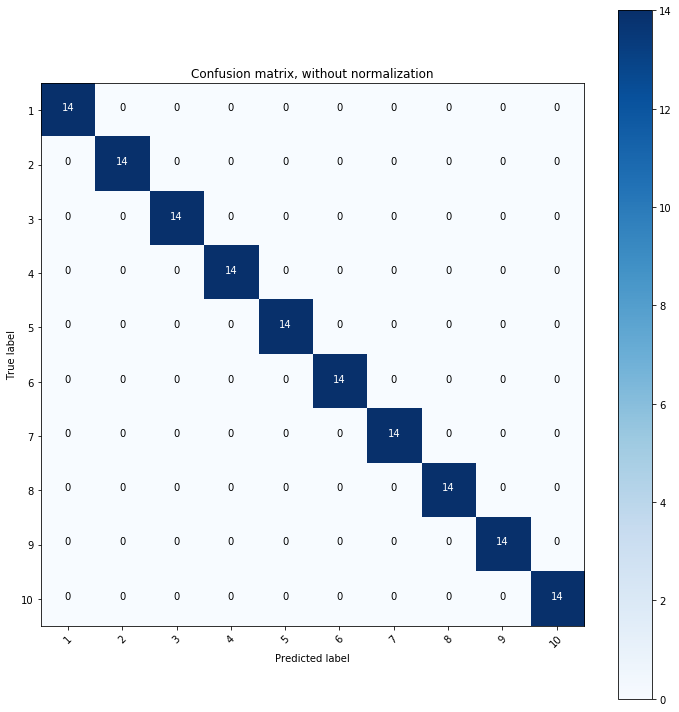

<Figure size 432x288 with 0 Axes>

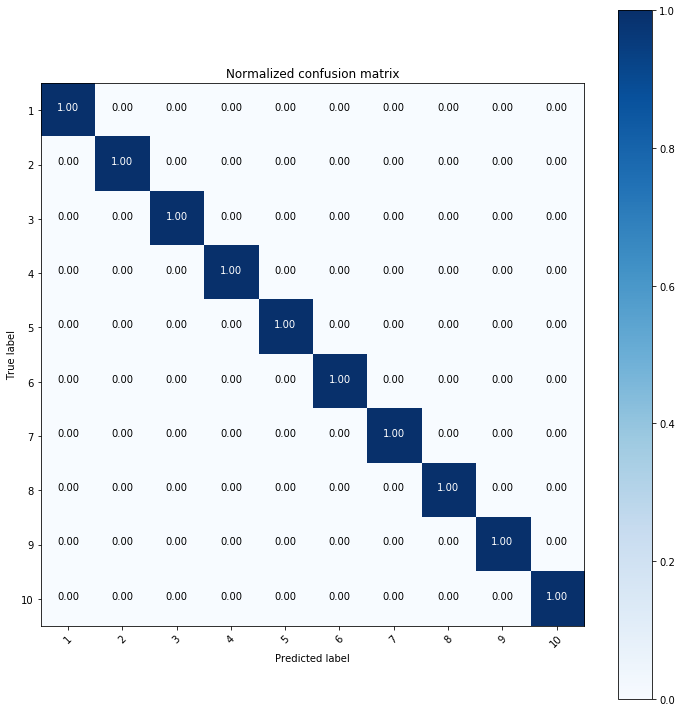

In [321]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(train_labels_svm, predicted_train_labels_svm)

In [322]:
#=========================
# load it again
with open('vgg16_svm_model/svm_classifier.pkl', 'rb') as fid:
    classifier_svm = pickle.load(fid)

In [323]:
predicted_test_labels_svm = classifier_svm.predict(test_data_svm) # getting the predicted labels
S = get_accuracy(test_labels_svm , predicted_test_labels_svm) # getting the accuracy
print ("The testing accuracy of my model using SVM is {:.2f}%".format(S*100))

The testing accuracy of my model using SVM is 100.00%


{1: '500vnd', 2: '1000vnd', 3: '2000vnd', 4: '5000vnd', 5: '10000vnd', 6: '20000vnd', 7: '50000vnd', 8: '100000vnd', 9: '200000vnd', 10: '500000vnd'}


<Figure size 432x288 with 0 Axes>

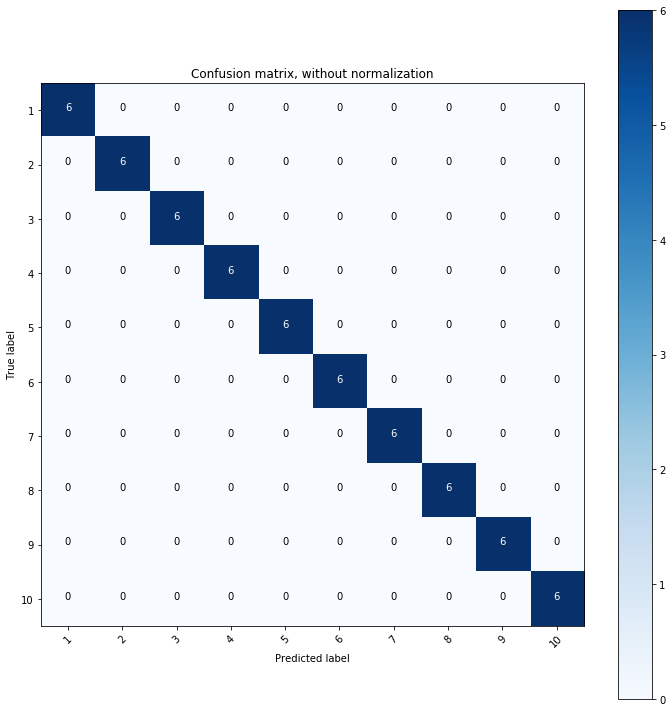

<Figure size 432x288 with 0 Axes>

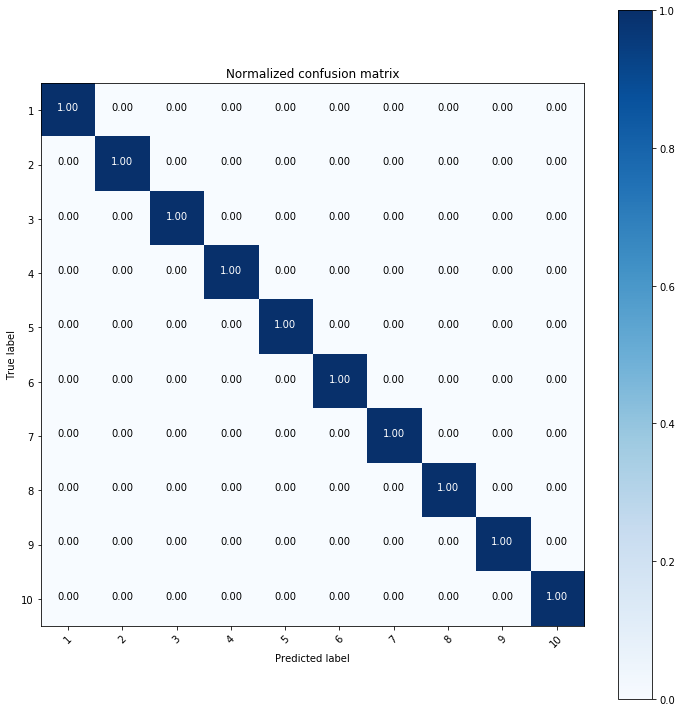

In [324]:
# here, we just want to show the labels that we are using
class_names_matrix = class_names_all[0:20]
class_names_matrix = dict(zip(range(1, len(class_names_matrix)+1), class_names_matrix))
print (class_names_matrix)
print_confusion_matrix(test_labels_svm, predicted_test_labels_svm)

In [191]:
#get models extract feature of image
vgg16 = models.vgg16(pretrained=True)
# function to modify the classifier
def change_classifier(classifier, position):
    temp_clas = list(classifier)
    temp_clas = temp_clas[0:position+1]
    temp_clas = nn.Sequential(*temp_clas)
    return temp_clas
vgg16.classifier = change_classifier(vgg16.classifier, 1)


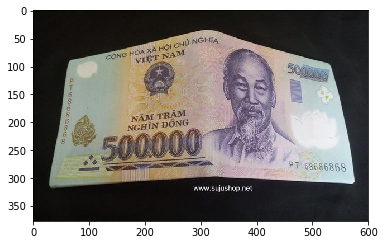

this is:  500000vnd


In [345]:
#indentify test with real image
#img_size = (300, 300)
img_size = (224, 224)
img = cv2.imread('data/test/500k.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# fig=plt.figure(figsize=(15, 15))
# for i, img1 in enumerate(get_five_crops(img, img_size)):
#     fig.add_subplot(1, 5, i+1)
#     plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()
#prepare image
data_image = []
feature = []
crops = prep_img(img, img_size)
for each in crops:
    data_image.append(np.transpose(each, [2, 0, 1]))

#transform data_image to tensor
minibatch_d = np.array(data_image)
minibatch_d = np.reshape(minibatch_d, (5, 3, img_size[0], img_size[1]))
data_image = torch.from_numpy(minibatch_d)

outputs = vgg16(Variable(data_image)) #using the pre-trained network to get outputs
del img # deleting images because we already extracted the features
temp = []
for each in outputs: # as each minibatch equals 1 frame
    temp.append(each) # we put it into an array so that we can average it easily
del outputs # free up more space
feature.append(avg_outputs(temp))

x = np.reshape(np.array(feature[0]), (4096,))
#predicted = classifier_svm.predict([test_data_svm[0]])
predicted = classifier_svm.predict([x])

print("this is: ", class_names[predicted[0]+1])

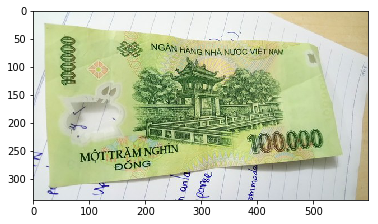

this is:  100000vnd


In [346]:
img_size = (224, 224)
img = cv2.imread('data/test/6.jpg')
arr = ['Top Left', 'Top Right', 'Bottom Left', 'Bottom right', 'Center']

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# fig=plt.figure(figsize=(15, 15))
# for i, img1 in enumerate(get_five_crops(img, img_size)):
#     fig.add_subplot(1, 5, i+1)
#     plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()
#prepare image
data_image = []
feature = []
crops = prep_img(img, img_size)
for each in crops:
    data_image.append(np.transpose(each, [2, 0, 1]))

#transform data_image to tensor
minibatch_d = np.array(data_image)
minibatch_d = np.reshape(minibatch_d, (5, 3, img_size[0], img_size[1]))
data_image = torch.from_numpy(minibatch_d)

outputs = vgg16(Variable(data_image)) #using the pre-trained network to get outputs
del img # deleting images because we already extracted the features
temp = []
for each in outputs: # as each minibatch equals 1 frame
    temp.append(each) # we put it into an array so that we can average it easily
del outputs # free up more space
feature.append(avg_outputs(temp))

x = np.reshape(np.array(feature[0]), (4096,))
#predicted = classifier_svm.predict([test_data_svm[0]])
predicted = classifier_svm.predict([x])

print("this is: ", class_names[predicted[0]+1])